In [206]:
import requests
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from functools import lru_cache
from time import sleep
import math

In [4]:
base_url = "https://demo.hafas.de/openapi/vbb-proxy/"

Read secret access ID for VBB API from a file

In [207]:
ACCESS_ID = !cat ACCESS_ID.txt
ACCESS_ID = ACCESS_ID.s

In [210]:
SLEEP = True

@lru_cache(maxsize=5000)
def req(endpoint):
    if SLEEP:
        sleep(10.) # sec
    response = requests.get(endpoint)
    js = json.loads(response.text)
    return js

In [7]:
# origin = (52.5159984,13.4575739)  # Frankfurter Allee 15
dest = (52.5219216,13.411026)  # Alexanderplatz
dest_extid = '900100003'
topleft = (52.58, 13.40)
bottomright = (52.50, 13.60)
num_points = 30
WALK_VELOCITY = 3.0/3.6

In [8]:
def append_access_id(endpoint):
    return endpoint + ('?','&')[endpoint.find('?') > -1] + "accessId={ACCESS_ID}".format(ACCESS_ID=ACCESS_ID)

def force_json_format(endpoint):
    return endpoint + ('?','&')[endpoint.find('?') > -1] + "format=json"

def set_latlon(endpoint, point, mode):
    return endpoint + ('?','&')[endpoint.find('?') > -1] + \
            "{mode}CoordLat={point[0]}".format(mode=mode, point=point) + '&' + \
            "{mode}CoordLon={point[1]}".format(mode=mode, point=point)

def set_origin_latlon(endpoint, point):
    return set_latlon(endpoint, point, 'origin')

def set_dest_latlon(endpoint, point):
    return set_latlon(endpoint, point, 'dest')

def set_extid(endpoint, extid, mode):
    return endpoint + ('?','&')[endpoint.find('?') > -1] + "{}ExtId={}".format(mode,extid)

def set_origin_extid(endpoint, extid):
    return set_extid(endpoint, extid, 'origin')

def set_dest_extid(endpoint, extid):
    return set_extid(endpoint, extid, 'dest')

def append_date_and_time(endpoint, datetime_):
    date_ = datetime_.strftime('%Y-%m-%d')
    time_ = datetime_.strftime('%H:%M:%S')
    duration = 20  # mins
    return endpoint + ('?','&')[endpoint.find('?') > -1] + "date={}&time={}&duration={}".format(date_, time_, duration)

def enable_walk_routes(endpoint):
    return enable_alt_routes(endpoint, 'Walk')

def enable_bike_routes(endpoint):
    return enable_alt_routes(endpoint, 'Bike')

def enable_alt_routes(endpoint, mode):
    return endpoint + ('?','&')[endpoint.find('?') > -1] + "total{0}=1,0,5000&origin{0}=1,0,5000&dest{0}=1,0,5000".format(mode)

Resolve origin and dest HAFAS locations using nearbystops

In [9]:
def get_closest_stop(point):
    endpoint = base_url + 'location.nearbystops'
    endpoint = append_access_id(endpoint)
    endpoint = force_json_format(endpoint)
    endpoint += '&originCoordLong={}&originCoordLat={}&maxNo=1&r=2000'.format(origin[1],origin[0])
    response = req(endpoint)
    for key, result in response.items():
        for location in result:
            # print(location['StopLocation'], location['StopLocation']['extId'])
            return location['StopLocation']
        
    return None

In [10]:
origin_ext = get_closest_stop(origin)
origin_extid = origin_ext['extId']

In [11]:
# pt = (52.52448133333333, 13.46405325)
# endpoint = base_url + 'location.nearbystops'
# endpoint = append_access_id(endpoint)
# endpoint = force_json_format(endpoint)
# endpoint += '&originCoordLong={}&originCoordLat={}&maxNo=1&r=1000'.format(pt[1],pt[0])
# response = req(endpoint)
# print(response)

Request all trips between origin and dest

In [28]:
def total_travel_time(response):
    ttt = []
    for trip in response['Trip']:
        leglist = trip['LegList']

        for key in leglist:
            travel_time = timedelta()
            for leg in leglist['Leg']:
                # print(leg, len(leg))
                leg_origin, leg_dest = leg['Origin'], leg['Destination']
                # print(leg_origin['time'], leg_dest['time'])
                leg_origin_time = datetime.strptime(leg_origin['time'], '%H:%M:%S')
                leg_dest_time = datetime.strptime(leg_dest['time'], '%H:%M:%S')
                # print(leg_dest)
                td = timedelta() + leg_dest_time - leg_origin_time
                travel_time += td
            # print('TOTAL TRAVEL TIME: {}'.format(travel_time))
            ttt.append(travel_time)
    return ttt

def all_trips(response):
    trips = []
    try:
        for trip in response['Trip']:
            leglist = trip['LegList']

            for key in leglist:
                travel_time = timedelta()
                legs = []
                for leg in leglist['Leg']:
                    # print(leg, len(leg))
                    leg_origin, leg_dest = leg['Origin'], leg['Destination']
                    if leg_origin['name'] not in legs:
                        legs.append(leg_origin['name'])
                    # print(leg_origin['time'], leg_dest['time'])
                    leg_origin_time = datetime.strptime(leg_origin['time'], '%H:%M:%S')
                    leg_dest_time = datetime.strptime(leg_dest['time'], '%H:%M:%S')
                    td = timedelta() + leg_dest_time - leg_origin_time
                    travel_time += td
                    legs.append(leg_dest['name'])
                # print('TOTAL TRAVEL TIME: {}'.format(travel_time))
                trips.append((travel_time, legs))
    except KeyError as e:
        if response['errorCode'] == 'SVC_NO_RESULT':
            # print('Could not find a trip')
            pass
        elif response['errorCode'] == 'SVC_LOC_EQUAL': # start and dest are equal -> 0 time
            trips.append((timedelta(seconds=0.0), ()),)
        else:
            print(e)
        
    return trips

def compute_travel_times(origin_extid, dest_extid, datetime_=None):
    endpoint = base_url + 'trip'
    endpoint = append_access_id(endpoint)
    endpoint = force_json_format(endpoint)
    endpoint = set_origin_extid(endpoint, origin_extid)
    endpoint = set_dest_extid(endpoint, dest_extid)
    endpoint = enable_walk_routes(endpoint)
    if datetime_ is not None:
        endpoint = append_date_and_time(endpoint, datetime_)
    return total_travel_time(req(endpoint))

def compute_trips(origin_extid, dest_extid, datetime_=None):
    endpoint = base_url + 'trip'
    endpoint = append_access_id(endpoint)
    endpoint = force_json_format(endpoint)
    endpoint = set_origin_extid(endpoint, origin_extid)
    endpoint = set_dest_extid(endpoint, dest_extid)
    endpoint = enable_walk_routes(endpoint)
    endpoint = enable_bike_routes(endpoint)
    if datetime_ is not None:
        endpoint = append_date_and_time(endpoint, datetime_)
    return all_trips(req(endpoint))

In [16]:
# compute_trips(origin_extid, dest_extid, datetime_=datetime(2020,5,12,8,0))

In [17]:
# compute_travel_times(origin_extid, dest_extid)

Consider distance from the requested GPS coordinate to the nearest stop

In [18]:
# origin = (52.517602, 13.458108)

In [19]:
# origin_closest_stop = get_closest_stop(origin)
# origin_extid = origin_closest_stop['extId']
# origin_closest_stop_coord = (origin_closest_stop['lat'], origin_closest_stop['lon'])

In [20]:
def distance_utf(point1, point2):
    def toRadians(deg):
        return deg * math.pi / 180.0
    
    R = 6371e3; # metres
    lat1, lon1 = point1
    lat2, lon2 = point2
    phi1 = toRadians(lat1)
    phi2 = toRadians(lat2)
    delta_phi = toRadians(lat2-lat1)
    delta_lambda = toRadians(lon2-lon1)

    a = math.sin(delta_phi/2) * math.sin(delta_phi/2) + \
            math.cos(phi1) * math.cos(phi2) * \
            math.sin(delta_lambda/2) * math.sin(delta_lambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    d = R * c
    return d

In [22]:
# travel_times = compute_travel_times(origin_extid, dest_extid)
# travel_times

In [21]:
# distance_utf(origin, origin_closest_stop_coord)

In [23]:
# WALK_VELOCITY = 3000/3600.0 # m/s
# distance_to_closest_stop = distance_utf(origin, origin_closest_stop_coord)
# travel_times_adjusted = []
# for tt in travel_times:
#     travel_times_adjusted.append(tt + timedelta(seconds=distance_to_closest_stop/WALK_VELOCITY))
# travel_times_adjusted

Record data into a CSV file for later rendering

In [20]:
# df = pd.DataFrame(columns=['latitude', 'longitude', 'min travel time'])

# origins = [
#     (52.5159984,13.4575739),
#     (52.517602, 13.458108)
# ]
# WALK_VELOCITY = 3000/3600.0 # m/s

# for origin in origins:
#     origin_closest_stop = get_closest_stop(origin)
#     distance_to_closest_stop = distance_utf(origin, origin_closest_stop_coord)
#     origin_extid = origin_closest_stop['extId']
#     origin_closest_stop_point = (origin_closest_stop['lat'], origin_closest_stop['lon'])
    
#     dt = datetime(2020, 5, 1, 5, 0, 0)
#     trips = compute_trips(origin_extid, dest_extid, dt)
    
#     trips_adjusted = []
#     for travel_time, trip in trips:
#         trips_adjusted.append((travel_time + timedelta(seconds=distance_to_closest_stop/WALK_VELOCITY), trip))

#     shortest_trip = sorted(trips_adjusted, key=lambda x:x[0])[0]
#     df = df.append({'latitude': origin[0], 'longitude': origin[1], 'min travel time': shortest_trip[0].total_seconds(), 'shortest trip': ' > '.join(shortest_trip[1])}, ignore_index=True)

In [25]:
# df

In [26]:
# df.to_csv('hafas_vbb.csv')

# Compute travel time for an equally spaced rectangular area

In [209]:
df = pd.DataFrame(columns=['latitude', 'longitude', 'min travel time'])

values = [] # 2d array
points = [] # GPS coords
# origins = []  # 1d array
lat_arr = np.linspace(bottomright[0], topleft[0], num_points)
lon_arr = np.linspace(bottomright[1], topleft[1], num_points)
for lat in lat_arr:
    row_points = []
    row_values = []
    for lon in lon_arr:
        # origins.append((lat, lon))
        origin = (lat, lon)
        
        origin_closest_stop = get_closest_stop(origin)
        origin_extid = origin_closest_stop['extId']
        origin_closest_stop_point = (origin_closest_stop['lat'], origin_closest_stop['lon'])
        distance_to_closest_stop = distance_utf(origin, origin_closest_stop_point)

        dt = datetime(2020, 5, 10, 5, 0, 0)
        trips = compute_trips(origin_extid, dest_extid, dt)
        trips_adjusted = []
        for travel_time, trip in trips:
            trips_adjusted.append((travel_time + timedelta(seconds=distance_to_closest_stop/WALK_VELOCITY), trip))

        sorted_trips = sorted(trips_adjusted, key=lambda x:x[0])
        if sorted_trips:
            shortest_trip = sorted_trips[0]
            shortest_trip_time = shortest_trip[0].total_seconds()
        else:
            shortest_trip = (distance_utf(origin, dest)/WALK_VELOCITY, ['No trip found'])
            shortest_trip_time = distance_utf(origin, dest)/WALK_VELOCITY
        shortest_trip_itinerary = shortest_trip[1]

        # time on foot
        time_on_foot = distance_utf(origin, dest)/WALK_VELOCITY

        df = df.append({'latitude': origin[0], 'longitude': origin[1], 'min travel time': shortest_trip_time, 'shortest trip': ' > '.join(shortest_trip_itinerary)}, ignore_index=True)
        row_points.append((lat, lon))
        row_values.append(shortest_trip_time)
        print('.', end='')
    points.append(row_points)
    values.append(row_values)
points = np.asarray(points)
values = np.asarray(values)

TypeError: string indices must be integers

# Convolve the distance image by a walking-time filter

Reduce high differences in neighboring blocks by analyzing the gradient of the distance image

In [174]:
point00 = (lat_arr[0], lon_arr[0])
point01 = (lat_arr[0], lon_arr[1])
point10 = (lat_arr[1], lon_arr[0])

In [175]:
distance_between_adjacent_points = (distance_utf(point00, point10), distance_utf(point00, point01)) # in meters

In [176]:
def flatten_array(arr, threshold=(2,2), iterations=2):
    ret = np.copy(arr)
    for iteration in range(iterations):
        grad_x = np.hstack([ret[:,:-1] - ret[:,1:], np.zeros((ret.shape[0], 1))])
        #print('GRAD X', grad_x)
        #print(grad_x>threshold[0])
        for (i,j) in np.argwhere(grad_x > threshold[0]):
            if grad_x[i][j] < 0:
                ret[i,j+1] -= np.abs(grad_x[i][j])-threshold[0]
            else:
                ret[i,j] -= np.abs(grad_x[i][j])-threshold[0]
                
        grad_y = np.vstack([ret[:-1]-ret[1:], np.zeros((1, ret.shape[1]))]) 
        for (i,j) in np.argwhere(grad_y > threshold[1]):
            if grad_y[i][j] < 0:
                ret[i+1,j] -= np.abs(grad_y[i][j])-threshold[1]
            else:
                ret[i,j] -= np.abs(grad_y[i][j])-threshold[1]
    return ret

In [177]:
flattened_values = flatten_array(values, threshold=distance_between_adjacent_points, iterations=2)

By now, the distance map has been regularized. Next step will be to increase resolution by interpolating this map.

# Interpolation

In [76]:
from scipy.interpolate import griddata

In [178]:
bottomleft = points.min(axis=0).min(axis=0)
topright = points.max(axis=0).max(axis=0)
NUM_INTERPOLATED_POINTS = 1000j
grid_x, grid_y = np.mgrid[bottomleft[0]:topright[0]:NUM_INTERPOLATED_POINTS, bottomleft[1]:topright[1]:NUM_INTERPOLATED_POINTS]

In [182]:
grid_z0 = griddata(points.reshape((num_points**2, 2)), flattened_values.reshape((num_points**2,)), (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points.reshape((num_points**2, 2)), flattened_values.reshape((num_points**2,)), (grid_x, grid_y), method='linear')
grid_z2 = griddata(points.reshape((num_points**2, 2)), flattened_values.reshape((num_points**2,)), (grid_x, grid_y), method='cubic')

In [143]:
import matplotlib.pyplot as plt

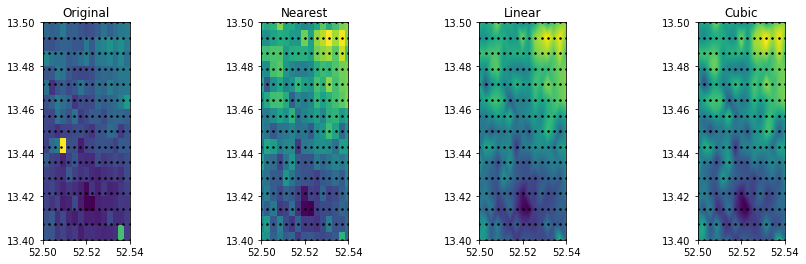

In [183]:
map_extent = (bottomleft[0],topright[0],bottomleft[1],topright[1])
fig, axes = plt.subplots(1, 4, figsize=(15,4))
grid_0 = values
axes[0].imshow(grid_0.T, extent=map_extent, origin='upper')
axes[0].plot(points[:,:,0], points[:,:,1], 'k.', ms=3)
axes[0].set_title('Original')
axes[1].imshow(grid_z0.T, extent=map_extent, origin='lower')
axes[1].plot(points[:,:,0], points[:,:,1], 'k.', ms=3)
axes[1].set_title('Nearest')
axes[2].imshow(grid_z1.T, extent=map_extent, origin='lower')
axes[2].plot(points[:,:,0], points[:,:,1], 'k.', ms=3)
axes[2].set_title('Linear')
axes[3].imshow(grid_z2.T, extent=map_extent, origin='lower')
axes[3].plot(points[:,:,0], points[:,:,1], 'k.', ms=3)
axes[3].set_title('Cubic')
plt.show()

In [184]:
np.save('./grid_z2.npy', grid_z2)

In [198]:
flattened_df = pd.DataFrame({'latitude': points.reshape((num_points**2, 2))[:,0], 'longitude': points.reshape((num_points**2, 2))[:,1], 'flattened trip time': flattened_values.reshape((num_points**2,))})

In [204]:
df = df.merge(flattened_df, on=('latitude', 'longitude'), suffixes=('original','flattened'))
df.to_csv('travel_index_map.csv')